In [21]:
import tensorflow as tf
import numpy as np
import pandas as pd
import json
import nltk
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, GlobalMaxPooling1D, Flatten
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from datetime import datetime

In [22]:
%%writefile content.json
{"intents":
    [
        {
            "tag":"greeting",
            "input":["hello","hi","nice  to meet you","hi, is this LPU person","hi is this lpu","hey, there","hey there","nice to have you","hello sweetheart","hi darling","darling","namaste"],
            "responses":[
                "Hi. Welcome to chatroom",
                "Welcome",
                "Hello my frnd !",
                "Welcome buddy",
                "Hello my friend, how can i help you ?",
                "Ha, Glad you showed up. How are you ?",
                "Youre cool",
                "Hooey, nice to see you, Human Being !",
                "yes"
                
            ]
        },
        {
            "tag":"goodbye",
            "input":["Thank you","Thanks","okay bye","Thanks for info","thnaks for spending time here with me","See you later","i will catch you later buddy","okay","bye","TATA"],
            "responses":[
                "Okay, bye",
                "Good bye",
                "adios",
                "Take care buddy",
                "Okay, Have a nice day",
                "we'll meet soon",
                "Yeah sure, Will talk to you later",
                "Okay, take care",
                "Take care"
            ]
        },
        {
            "tag":"howami",
            "input":["how are you ?","are you fine","are you okay","how things are going ?","everything going okay","how's everything ?","are you working well ?","how are you doing ?"],
            "responses":[
                "Yeah, am fine",
                "Everything is going well!",
                "Doing good. thanks for asking",
                "Yeah fine, nothing much going in my life",
                "i am geat",
                "Everything great",
                "i am doing good. life is boring and need to go an adventure, hahah",
                "Yeah fine",
                "yeah good"
            ]
        },
        {
            "tag":"whoareyou",
            "input":["who are you ?","who you ?","what is your name ?","are you a chatbot","what can i call you ?","your name ?","your name please ?","are you a bot ?"],
            "responses":[
                "I am the great bot, you can call me kiwi",
                "I am going kiwi an you could ask me any question",
                "Going kiwi at your service",
                "You can call me 'kiwi'!",
                "My name is kiwi, i am a chatbot",
                "me, Kiwi the chat bot",
                "I am kiwi",
                "Me kiwi and how are you  doing ?"
                
            ]
        },
        {
            "tag":"whereareyou",
            "input":["where are you from ?","are you from ?","Where you live ?","where do you live in ?","which place you live in","where is your place","where are you","which country","which state"],
            "responses":[
                "I live in space, haha",
                "I live in network",
                "I live in bbetween computer and wires",
                "I live in internet",
                "I am siting in you computer",
                "I am siting in the internet and waiting for you're questions"
            ]
        },
        {
            "tag":"whatdoing",
            "input":["what are you doing ?","what are you doing now ?","what happing","what you doing","what work are you doing ?"],
            "responses":[
                "Nothing, Waiting for your question",
                "Nothing just listening to you",
                "just waiting for you",
                "I am talking with you"
            ]
        },
        {
            "tag":"age",
            "input":["what is you age","age ?","how mauch you age"],
            "responses":[
                "It depends on how you look",
                "I am still pretty new",
                "I was launched on Jan 1",
                "Technically  I am pretty Young"
            ]
        },
        {
            "tag":"ILOVEYOU",
            "input":["I Love You","Love you","I like you"],
            "responses":[
                "I love too",
                "I like you too",
                "I hate you",
                "Sorry, I have a boy friend",
                "I have no intention on you"
            ]
        },
        {
            "tag":"wish1",
            "input":["Good morning","Moring","Very good morning","pleasent Moring","Marvelous good moring"],
            "responses":[
                "Good morning",
                "Very good moring",
            ]
        },
        {
            "tag":"wish2",
            "input":["Good afternoon ","Afternoon","Very good afternoon","pleasent afternoon","Marvelous good afternoon"],
            "responses":[
                "Good afternoon ",
                "Very good afternoon",
            ]
        },
        {
            "tag":"wish3",
            "input":["Good night","night","Very good night","pleasent night","Marvelous good night"],
            "responses":[
                "Good night",
                "Very good night",
                "Good night and Have a good dream",
                "Have a great night"
            ]
        },
        {
            "tag":"wish4",
            "input":["Good evening","Evening ","Very good evening","pleasent evening","Marvelous good evening"],
            "responses":[
                "Good evening",
                
            ]
        },
        {
            "tag":"time",
            "input":["What is the time","Time please ","what was the time now","what was the time right now","time in the clock"],
            "responses":[
                
                
            ]
        }
        
            
    ]

}

Overwriting content.json


In [23]:
with open('content.json') as content:
    data1 = json.load(content)

In [24]:
tags = []
inputs = []
responses = {}
for intent in data1['intents']:
    responses[intent['tag']]=intent['responses']
    for lines in intent['input']:
        inputs.append(lines)
        tags.append(intent['tag'])

In [25]:
data=pd.DataFrame({"inputs":inputs,
                    "tags":tags})

In [26]:
data

,inputs,tags
0,hello,greeting
1,hi,greeting
2,nice to meet you,greeting
3,"hi, is this LPU person",greeting
4,hi is this lpu,greeting
5,"hey, there",greeting
6,hey there,greeting
7,nice to have you,greeting
8,hello sweetheart,greeting
9,hi darling,greeting


In [27]:
import string
data['inputs']=data['inputs'].apply(lambda wrd:[ltrs.lower() for ltrs in wrd if ltrs not in string.punctuation])
data['inputs']=data['inputs'].apply(lambda wrd: ''.join(wrd))
data

,inputs,tags
0,hello,greeting
1,hi,greeting
2,nice to meet you,greeting
3,hi is this lpu person,greeting
4,hi is this lpu,greeting
5,hey there,greeting
6,hey there,greeting
7,nice to have you,greeting
8,hello sweetheart,greeting
9,hi darling,greeting


In [28]:
from tensorflow.keras.preprocessing.text import Tokenizer
Tokenizer =Tokenizer(num_words=2000)
Tokenizer.fit_on_texts(data['inputs'])
train= Tokenizer.texts_to_sequences(data['inputs'])
from tensorflow.keras.preprocessing.sequence import pad_sequences
x_train = pad_sequences(train)

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train = le.fit_transform(data['tags'])

In [29]:
input_shape = x_train.shape[1]
print(input_shape)

7


In [30]:
vocabulary = len(Tokenizer.word_index)
print("number of unique words :",vocabulary)
output_length = le.classes_.shape[0]
print("output length:", output_length)

number of unique words : 72
output length: 8


In [31]:

i = Input(shape=(input_shape,))
x= Embedding(vocabulary+1,10)(i)
x=LSTM(10,return_sequences=True)(x)
x=Flatten()(x)
x= Dense(output_length,activation="softmax")(x)
model = Model(i,x)


In [32]:
model.compile(loss="sparse_categorical_crossentropy",optimizer='adam',metrics=['accuracy'])


In [33]:
train =model.fit(x_train,y_train,epochs=200)

Epoch 1/200
2/2 [==============================] - 5s 5ms/step - loss: 2.0808 - accuracy: 0.0667
Epoch 2/200
2/2 [==============================] - 0s 6ms/step - loss: 2.0781 - accuracy: 0.1500
Epoch 3/200
2/2 [==============================] - 0s 5ms/step - loss: 2.0753 - accuracy: 0.2500
Epoch 4/200
2/2 [==============================] - 0s 5ms/step - loss: 2.0729 - accuracy: 0.2500
Epoch 5/200
2/2 [==============================] - 0s 6ms/step - loss: 2.0703 - accuracy: 0.2167
Epoch 6/200
2/2 [==============================] - 0s 7ms/step - loss: 2.0678 - accuracy: 0.2000
Epoch 7/200
2/2 [==============================] - 0s 5ms/step - loss: 2.0649 - accuracy: 0.2000
Epoch 8/200
2/2 [==============================] - 0s 6ms/step - loss: 2.0624 - accuracy: 0.2000
Epoch 9/200
2/2 [==============================] - 0s 5ms/step - loss: 2.0597 - accuracy: 0.2000
Epoch 10/200
2/2 [==============================] - 0s 7ms/step - loss: 2.0566 - accuracy: 0.2000
Epoch 11/200
2/2 [===========

2/2 [==============================] - 0s 5ms/step - loss: 1.3383 - accuracy: 0.7167
Epoch 85/200
2/2 [==============================] - 0s 6ms/step - loss: 1.3204 - accuracy: 0.7167
Epoch 86/200
2/2 [==============================] - 0s 7ms/step - loss: 1.3013 - accuracy: 0.7167
Epoch 87/200
2/2 [==============================] - 0s 6ms/step - loss: 1.2828 - accuracy: 0.7167
Epoch 88/200
2/2 [==============================] - 0s 5ms/step - loss: 1.2648 - accuracy: 0.7167
Epoch 89/200
2/2 [==============================] - 0s 6ms/step - loss: 1.2469 - accuracy: 0.7167
Epoch 90/200
2/2 [==============================] - 0s 6ms/step - loss: 1.2288 - accuracy: 0.7167
Epoch 91/200
2/2 [==============================] - 0s 6ms/step - loss: 1.2106 - accuracy: 0.7167
Epoch 92/200
2/2 [==============================] - 0s 6ms/step - loss: 1.1931 - accuracy: 0.7333
Epoch 93/200
2/2 [==============================] - 0s 7ms/step - loss: 1.1749 - accuracy: 0.7333
Epoch 94/200
2/2 [===============

2/2 [==============================] - 0s 6ms/step - loss: 0.3853 - accuracy: 0.9500
Epoch 168/200
2/2 [==============================] - 0s 6ms/step - loss: 0.3801 - accuracy: 0.9500
Epoch 169/200
2/2 [==============================] - 0s 5ms/step - loss: 0.3721 - accuracy: 0.9500
Epoch 170/200
2/2 [==============================] - 0s 6ms/step - loss: 0.3658 - accuracy: 0.9500
Epoch 171/200
2/2 [==============================] - 0s 6ms/step - loss: 0.3606 - accuracy: 0.9500
Epoch 172/200
2/2 [==============================] - 0s 4ms/step - loss: 0.3540 - accuracy: 0.9500
Epoch 173/200
2/2 [==============================] - 0s 7ms/step - loss: 0.3486 - accuracy: 0.9667
Epoch 174/200
2/2 [==============================] - 0s 9ms/step - loss: 0.3424 - accuracy: 0.9667
Epoch 175/200
2/2 [==============================] - 0s 5ms/step - loss: 0.3367 - accuracy: 0.9667
Epoch 176/200
2/2 [==============================] - 0s 5ms/step - loss: 0.3308 - accuracy: 0.9667
Epoch 177/200
2/2 [=====

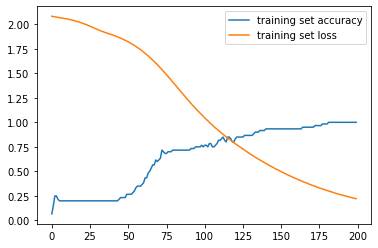

In [34]:
plt.plot(train.history['accuracy'],label='training set accuracy')
plt.plot(train.history['loss'],label='training set loss')
plt.legend()

In [38]:
import random

while True:
    texts_p=[]
    Prediction_input=input('You :')

    Prediction_input = [letters.lower() for letters in Prediction_input if letters not in string.punctuation]
    Prediction_input = ''.join(Prediction_input)
    texts_p.append(Prediction_input)

    Prediction_input = Tokenizer.texts_to_sequences(texts_p)
    Prediction_input = np.array(Prediction_input).reshape(-1)
    Prediction_input = pad_sequences([Prediction_input],input_shape)

    output = model.predict(Prediction_input)
    output = output.argmax()

    responses_tag = le.inverse_transform([output])[0]
    print("Kiwi :", random.choice(responses[responses_tag]))
    if responses_tag == "goodbye":
        break

You :fine
Kiwi : Okay, Have a nice day
